## Analysis of spam SMS messages (data from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/))

In [ ]:
ls

In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df=pd.read_csv('data/SMSSpamCollection',sep='\t',header=None,names=['class','text'])

In [3]:
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df['text_len'] = df['text'].apply(len)

In [5]:
df.head()

,class,text,text_len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [6]:
pd.set_option('display.max_colwidth', 500)

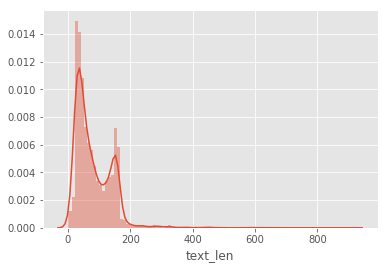

In [7]:
sns.distplot(df.text_len,bins='auto')

In [8]:
df['class'].value_counts()

ham     4825
spam     747
Name: class, dtype: int64

In [9]:
spam = df['class'] == 'spam'
df_spam = df[spam]


ham = df['class'] == 'ham'
df_ham = df[ham]


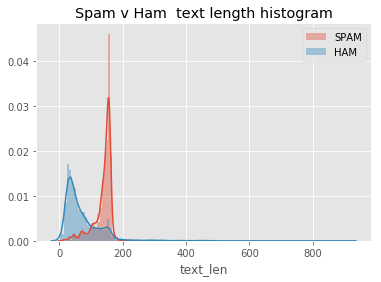

In [10]:
sns.distplot(df_spam.text_len,bins='auto',label='SPAM')
sns.distplot(df_ham.text_len,bins='auto',label='HAM')
plt.legend()
plt.title('Spam v Ham  text length histogram')
plt.show()

## Split into test data and training data

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'], test_size=0.25)

## Some Pre-processing

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer

In [14]:
count_vect = CountVectorizer()

In [15]:
X_train_counts = count_vect.fit_transform(X_train)

In [22]:
X_train_counts

<4179x7499 sparse matrix of type '<class 'numpy.int64'>'
	with 55743 stored elements in Compressed Sparse Row format>

In [25]:
list(count_vect.vocabulary_.items())[:10]

[('see', 5800),
 ('the', 6599),
 ('letter', 3972),
 ('on', 4786),
 ('my', 4519),
 ('car', 1608),
 ('oi', 4764),
 ('ami', 921),
 ('parchi', 4926),
 ('na', 4529)]

In [26]:
list(count_vect.vocabulary_.items())[-10:]

[('wasting', 7160),
 ('justbeen', 3760),
 ('overa', 4878),
 ('brains', 1444),
 ('mush', 4508),
 ('pobox202', 5114),
 ('nr31', 4703),
 ('7zs', 608),
 ('450pw', 480),
 ('930', 702)]

In [33]:
len(count_vect.vocabulary_)

7499

In [44]:
lab_bin=LabelBinarizer()
y_train_bin=lab_bin.fit_transform(y_train)  # converts 'ham' 'spam' to 0,1
y_test_bin=lab_bin.fit_transform(y_test)   # converts 'ham' 'spam' to 0,1

In [48]:
type(y_train_bin)

numpy.ndarray

In [52]:
ravel?

Object `ravel` not found.


In [53]:
y_train_bin.ravel()  # Return a contiguous flattened array.


array([0, 0, 0, ..., 1, 0, 0])

## Train

In [55]:
from sklearn.naive_bayes import MultinomialNB

In [56]:
clf = MultinomialNB()

In [58]:
clf.fit(X_train_counts, y_train_bin.ravel())

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [59]:
len(clf.coef_[0])

7499

In [60]:
import collections

In [61]:
importanceCount=collections.Counter()

In [62]:
for word,imp in zip(count_vect.vocabulary_.keys(),clf.coef_[0]):
    importanceCount[word]=imp

In [63]:
importanceCount.most_common()[:10]

[('a30', -3.681399626744718),
 ('especially', -4.413767520457945),
 ('legitimat', -4.492810727798398),
 ('follows', -4.688204366159705),
 ('sarasota', -4.799430001269929),
 ('unknown', -4.841478237513429),
 ('48', -4.917948601505267),
 ('hella', -4.9654151387441905),
 ('aluable', -4.97940138071893),
 ('applebees', -5.052426515733821)]

In [64]:
importanceCount.most_common()[-10:]

[('babysitting', -9.935228438320191),
 ('wasting', -9.935228438320191),
 ('justbeen', -9.935228438320191),
 ('overa', -9.935228438320191),
 ('brains', -9.935228438320191),
 ('mush', -9.935228438320191),
 ('pobox202', -9.935228438320191),
 ('7zs', -9.935228438320191),
 ('450pw', -9.935228438320191),
 ('930', -9.935228438320191)]

## Now test

In [65]:
X_test_counts = count_vect.transform(X_test)

In [66]:
pred=clf.predict(X_test_counts)

In [67]:
from sklearn.metrics import average_precision_score

In [71]:
average_precision_score(y_test_bin,pred)

0.908562472416224

## Sanity check

In [72]:
clf.predict(count_vect.transform(['win big on this offer']))

array([1])

In [73]:
clf.predict(count_vect.transform(['hi how are you? shall we meet up soon?']))

array([0])

In [74]:
clf.predict_proba(count_vect.transform(['hi how are you? shall we meet up soon?']))

array([[9.99999727e-01, 2.73433326e-07]])

In [75]:
clf.predict(count_vect.transform(['Hey why wondt you reply my text?']))

array([0])

In [76]:
clf.predict_proba(count_vect.transform(['Cheap viagra']))

array([[0.84962775, 0.15037225]])

In [77]:
clf

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [78]:
clf.predict_proba(count_vect.transform(['hi how are you? shall we meet up soon?']))

array([[9.99999727e-01, 2.73433326e-07]])